In [ ]:
! pip install nilearn

In [7]:
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, BayesianRidge, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from time import time

import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.linalg import LinAlgWarning
warnings.filterwarnings('ignore', category=LinAlgWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# **Dataset A**

In [4]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=200) # this needs to be modified for  some tasks
print('%i regions found in this atlas' % (len(np.unique(nib.load(yeo.maps).get_fdata().ravel()))  - 1))
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True,   memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int) # gives 1 for females  and 0 for males

200 regions found in this atlas


### **Question 1**

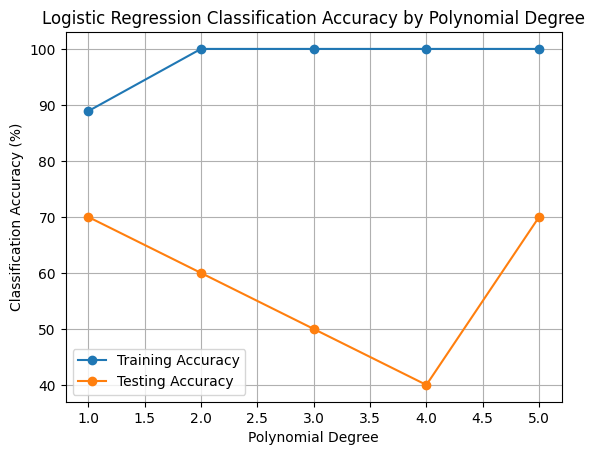

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=100)
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int)  # 1 for females, 0 for males

input_variables = input_variables[:,:50] # Use only first 50 columns of input variables
X_train, X_test = input_variables[:90], input_variables[90:] # Get first 90 samples for train set
y_train, y_test = output_variable[:90], output_variable[90:] # Last 90 samples for test set

train_accuracies, test_accuracies = [], [] # Store training and testing accuracies

for degree in range(1, 6): # Iterate through degrees 1 to 5
    poly = PolynomialFeatures(degree=degree) # Create PolynomialFeatures object
    X_train_poly = poly.fit_transform(X_train) # Fit & transform training data
    X_test_poly = poly.transform(X_test) # Transform testing data
    
    log_model_q1 = LogisticRegression() # Create log model
    log_model_q1.fit(X_train_poly, y_train) # Fit model on training data
    y_train_pred = log_model_q1.predict(X_train_poly) # Predict on training data
    y_test_pred = log_model_q1.predict(X_test_poly) # Predict on testing data
    
    train_accuracies.append(accuracy_score(y_train, y_train_pred)*100) # Calculate training accuracy
    test_accuracies.append(accuracy_score(y_test, y_test_pred)*100) # Calculate testing accuracy

# Plot the results
plt.plot(range(1,6), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1,6), test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Classification Accuracy (%)')
plt.title('Logistic Regression Classification Accuracy by Polynomial Degree')
plt.legend()
plt.grid()
plt.show()

### **Question 2**

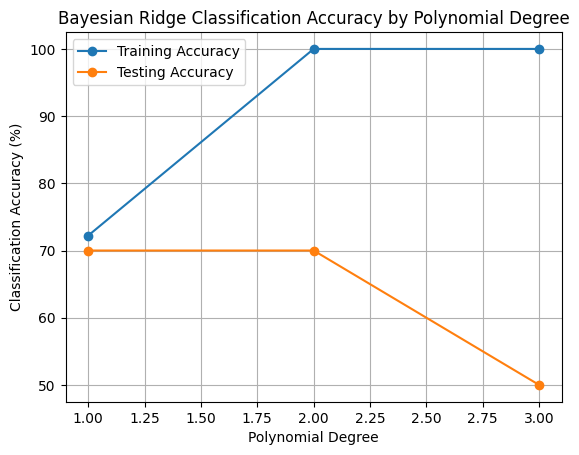

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=100)
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int) # 1 for females, 0 for males

input_variables = input_variables[:,:50] # Use only first 50 columns of input variables
output_variable = 2 * output_variable - 1 # Encode binary outcome (0, 1) as (-1, 1)
X_train, X_test = input_variables[:90], input_variables[90:] # Get first 90 samples for train set
y_train, y_test = output_variable[:90], output_variable[90:] # Last 90 samples for test set

train_accuracies, test_accuracies = [], [] # Store training and testing accuracies
degrees=range(1, 4) # Trying this so the kernel doesn't crash

for degree in degrees: # Iterate through degrees
    poly = PolynomialFeatures(degree=degree) # Create PolynomialFeatures object
    X_train_poly = poly.fit_transform(X_train) # Fit & transform training data
    X_test_poly = poly.transform(X_test) # Transform testing data
    
    model_q2 = BayesianRidge() # Create Bayesian Ridge model
    model_q2.fit(X_train_poly, y_train) # Fit model on training data
    y_train_pred = np.sign(model_q2.predict(X_train_poly)) # Predict on training data
    y_test_pred = np.sign(model_q2.predict(X_test_poly)) # Predict on testing data
    
    train_accuracies.append(accuracy_score(y_train, y_train_pred)*100) # Calculate training accuracy
    test_accuracies.append(accuracy_score(y_test, y_test_pred)*100) # Calculate testing accuracy

# Plot the results
plt.plot(degrees, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(degrees, test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Classification Accuracy (%)')
plt.title('Bayesian Ridge Classification Accuracy by Polynomial Degree')
plt.legend()
plt.grid()
plt.show()

### **Question 3**

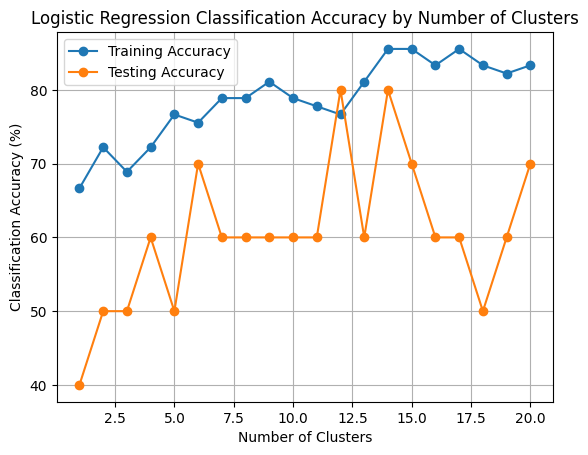

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=100)
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int)  # 1 for females, 0 for males

X_train, X_test = input_variables[:90], input_variables[90:] # Get first 90 samples for train set
y_train, y_test = output_variable[:90], output_variable[90:] # Last 90 samples for test set
train_accuracies, test_accuracies = [], [] # Store training and testing accuracies

for n_clusters in range(1, 21): # Iterate through number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42) # Create KMeans object
    train_input=kmeans.fit_transform(X_train) # Fit & transform training data
    test_input=kmeans.transform(X_test) # Transform testing data

    poly = PolynomialFeatures(degree=2) # Create PolynomialFeatures object with degree 2
    X_train_poly = poly.fit_transform(train_input) # Fit & transform training data
    X_test_poly = poly.transform(test_input) # Transform testing data
    
    log_model_q3 = LogisticRegression() # Creat log model
    log_model_q3.fit(X_train_poly, y_train) # Fit model on training data
    y_train_pred = log_model_q3.predict(X_train_poly) # Predict on training data
    y_test_pred = log_model_q3.predict(X_test_poly) # Predict on testing data
    
    train_accuracies.append(accuracy_score(y_train, y_train_pred)*100) # Calculate training accuracy
    test_accuracies.append(accuracy_score(y_test, y_test_pred)*100) # Calculate testing accuracy

# Plot the results
plt.plot(range(1, 21), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, 21), test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Classification Accuracy (%)')
plt.title('Logistic Regression Classification Accuracy by Number of Clusters')
plt.legend()
plt.grid()
plt.show()

### **Question 4**

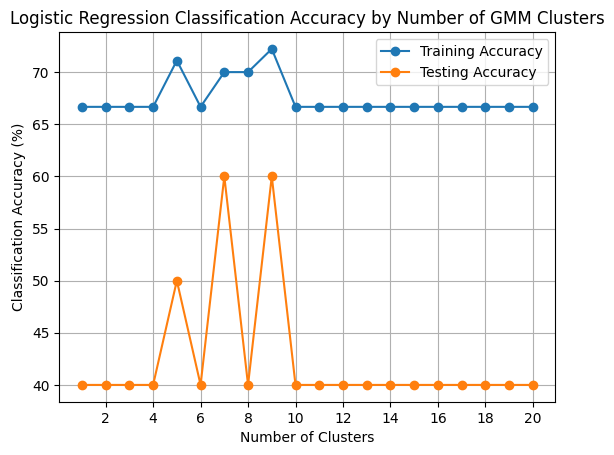

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=100)
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int)  # 1 for females, 0 for males

X_train, X_test = input_variables[:90], input_variables[90:] # Get first 90 samples for train set
y_train, y_test = output_variable[:90], output_variable[90:] # Last 90 samples for test set
train_accuracies, test_accuracies = [], [] # Lists for train & test accuracies

for n_clusters in range(1, 21): # Iterate through number of clusters
    gmm = GaussianMixture(n_components=n_clusters, random_state=42) # Create GMM object
    gmm.fit(X_train) # Fit GMM on training data
    train_input = gmm.predict(X_train).reshape(-1, 1) # Predict on training data
    test_input = gmm.predict(X_test).reshape(-1, 1) # Predict on testing data

    poly = PolynomialFeatures(degree=2) # Create PolynomialFeatures object with degree 2
    X_train_poly = poly.fit_transform(train_input) # Fit & transform training data
    X_test_poly = poly.transform(test_input) # Transform testing data
    
    log_model_q4 = LogisticRegression() # Create log model
    log_model_q4.fit(X_train_poly, y_train) # Fit model on training data
    y_train_pred = log_model_q4.predict(X_train_poly) # Predict on training data
    y_test_pred = log_model_q4.predict(X_test_poly) # Predict on testing data
    
    train_accuracies.append(accuracy_score(y_train, y_train_pred)*100) # Calculate train accuracy
    test_accuracies.append(accuracy_score(y_test, y_test_pred)*100) # Calculate test accuracy

# Plot the results
plt.plot(range(1,21), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1,21), test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Classification Accuracy (%)')
plt.xticks(range(2,22,2))
plt.title('Logistic Regression Classification Accuracy by Number of GMM Clusters')
plt.legend()
plt.grid()
plt.show()

### **Question 5**

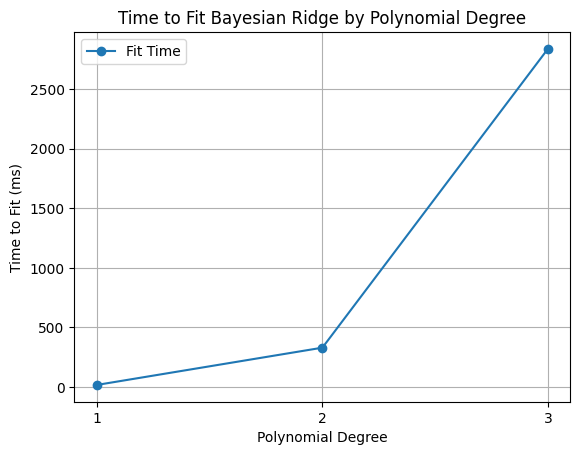

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=100)
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = 2 * (np.array(brain_data.ext_vars.mf == 'F', dtype=int) - 0.5)  # Encode as +1/-1

input_variables = input_variables[:,:50] # First 50 columns
X_train, X_test = input_variables[:90], input_variables[90:] # First 90 as train set
y_train, y_test = output_variable[:90], output_variable[90:] # Last 10 as test set

degrees = range(1, 4) # Degrees 1 to 3
fit_times = [] # Store fit times

for degree in degrees: # Iterate through degrees
    poly = PolynomialFeatures(degree=degree) # Create PolynomialFeatures object
    X_train_poly = poly.fit_transform(X_train) # Fit & transform training data
    
    model_q5 = BayesianRidge() # Create Bayesian Ridge model
    start_time = time() # Start time
    model_q5.fit(X_train_poly, y_train) # Fit model on training data
    end_time = time() # End time

    fit_time_ms = (end_time - start_time)*1000 # Convert to milliseconds
    fit_times.append(fit_time_ms) # Store the fit time

# Plot the results
plt.plot(degrees, fit_times, marker='o', label='Fit Time')
plt.xlabel('Polynomial Degree')
plt.ylabel('Time to Fit (ms)')
plt.xticks(degrees)
plt.title('Time to Fit Bayesian Ridge by Polynomial Degree')
plt.grid()
plt.legend()
plt.show()

# **Dataset B**

In [6]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 42) # this needs to be modified for some tasks
print('%i regions found in this atlas' % (len(np.unique(atlas_nii.get_fdata().ravel())) - 1))
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] #  gives subject age on standard units after z-scoring

788 regions found in this atlas


### **Question 6**

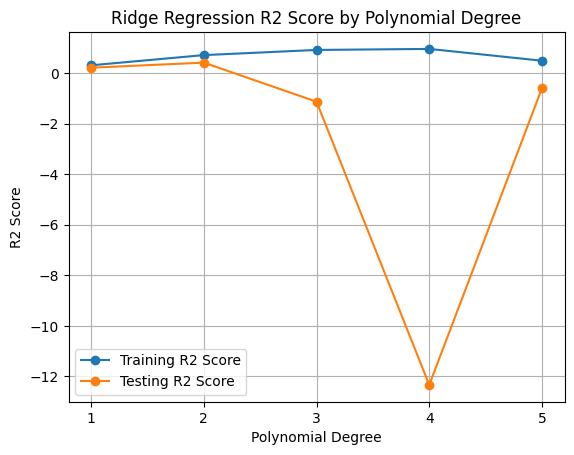

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 0) # Use lowest resolution atlas
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] #  gives subject age on standard units after z-scoring

input_variables = input_variables[:,:50] # Use only first 50 columns of input variables
X_train, X_test = input_variables[:90], input_variables[90:] # Get first 90 samples for train set
y_train, y_test = output_variable[:90], output_variable[90:] # Last 90 samples for test set

train_r2, test_r2 = [], [] # Store training and testing R2 scores

for degree in range(1, 6): # Iterate through degrees 1 to 5
    poly = PolynomialFeatures(degree=degree) # Create PolynomialFeatures object
    X_train_poly = poly.fit_transform(X_train) # Fit & transform training data
    X_test_poly = poly.transform(X_test) # Transform testing data
    
    model_q6 = Ridge() # Create ridge model
    model_q6.fit(X_train_poly, y_train) # Fit model
    y_train_pred = model_q6.predict(X_train_poly) # Predict on training data
    y_test_pred = model_q6.predict(X_test_poly) # Predict on testing data
    
    train_r2.append(r2_score(y_train, y_train_pred)) # Calculate training R2
    test_r2.append(r2_score(y_test, y_test_pred)) # Calculate testing R2

# Plot the results
plt.plot(range(1,6), train_r2, label='Training R2 Score', marker='o')
plt.plot(range(1,6), test_r2, label='Testing R2 Score', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('R2 Score')
plt.xticks(range(1,6))
plt.title('Ridge Regression R2 Score by Polynomial Degree')
plt.legend()
plt.grid()
plt.show()

### **Question 7**

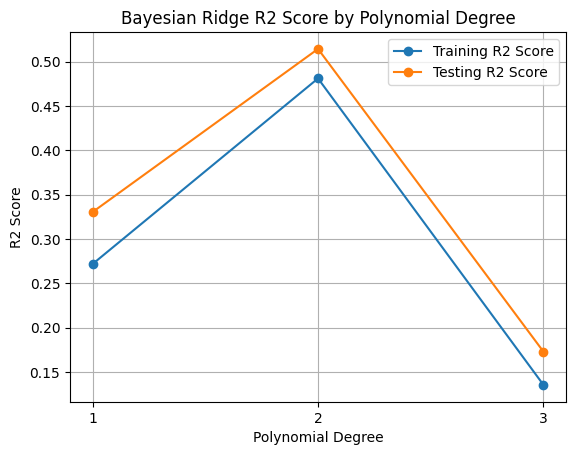

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 0) # Use lowest resolution atlas
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] #  gives subject age on standard units after z-scoring

input_variables = input_variables[:,:50] # Use only first 50 columns of input variables
#output_variable = 2 * output_variable - 1 # Encode binary outcome (0, 1) as (-1, 1)
X_train, X_test = input_variables[:90], input_variables[90:] # Get first 90 samples for train set
y_train, y_test = output_variable[:90], output_variable[90:] # Last 90 samples for test set

train_r2, test_r2 = [], [] # Store training and testing accuracies
degrees=range(1, 4) # Trying this so the kernel doesn't crash

for degree in degrees: # Iterate through degrees
    poly = PolynomialFeatures(degree=degree) # Create PolynomialFeatures object
    X_train_poly = poly.fit_transform(X_train) # Fit & transform training data
    X_test_poly = poly.transform(X_test) # Transform testing data
    
    model_q7 = BayesianRidge() # Create Bayesian Ridge model
    model_q7.fit(X_train_poly, y_train) # Fit model
    y_train_pred = model_q7.predict(X_train_poly) # Predict on training data
    y_test_pred = model_q7.predict(X_test_poly) # Predict on testing data
    
    train_r2.append(r2_score(y_train, y_train_pred)) # Calculate training R2
    test_r2.append(r2_score(y_test, y_test_pred)) # Calculate testing R2

# Plot the results
plt.plot(degrees, train_r2, label='Training R2 Score', marker='o')
plt.plot(degrees, test_r2, label='Testing R2 Score', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('R2 Score')
plt.xticks(degrees)
plt.title('Bayesian Ridge R2 Score by Polynomial Degree')
plt.legend()
plt.grid()
plt.show()

### **Question 8**

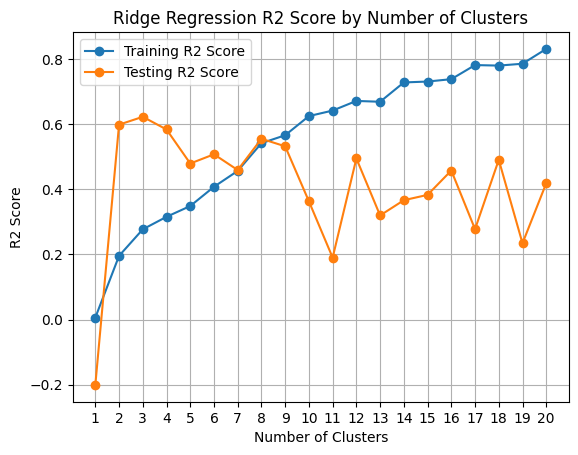

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 0) # Use lowest resolution atlas
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] #  gives subject age on standard units after z-scoring

X_train, X_test = input_variables[:90], input_variables[90:] # Get first 90 samples for train set
y_train, y_test = output_variable[:90], output_variable[90:] # Last 90 samples for test set
train_r2, test_r2 = [], [] # Store training and testing accuracies

for n_clusters in range(1, 21): # Iterate through number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42) # Create KMeans object
    train_input=kmeans.fit_transform(X_train) # Fit & transform training data
    test_input=kmeans.transform(X_test) # Transform testing data

    poly = PolynomialFeatures(degree=2) # Create PolynomialFeatures object with degree 2
    X_train_poly = poly.fit_transform(train_input) # Fit & transform training data
    X_test_poly = poly.transform(test_input) # Transform testing data
    
    model_q8 = Ridge() # Create log model
    model_q8.fit(X_train_poly, y_train) # Fit model on training data
    y_train_pred = model_q8.predict(X_train_poly) # Predict on training data
    y_test_pred = model_q8.predict(X_test_poly) # Predict on testing data
    
    train_r2.append(r2_score(y_train, y_train_pred)) # Calculate training R2
    test_r2.append(r2_score(y_test, y_test_pred)) # Calculate testing R2

# Plot the results
plt.plot(range(1, 21), train_r2, label='Training R2 Score', marker='o')
plt.plot(range(1, 21), test_r2, label='Testing R2 Score', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('R2 Score')
plt.xticks(range(1,21))
plt.title('Ridge Regression R2 Score by Number of Clusters')
plt.legend()
plt.grid()
plt.show()

### **Question 9**

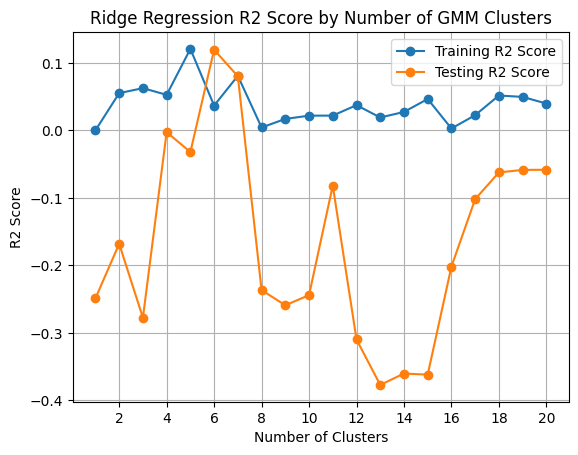

In [13]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 0) # Use lowest resolution atlas
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] #  gives subject age on standard units after z-scoring

X_train, X_test = input_variables[:90], input_variables[90:] # Get first 90 samples for train set
y_train, y_test = output_variable[:90], output_variable[90:] # Last 90 samples for test set
train_r2, test_r2 = [], [] # Lists for train & test R2 scores

for n_clusters in range(1, 21): # Iterate through number of clusters
    gmm = GaussianMixture(n_components=n_clusters, random_state=42) # Create GMM object
    gmm.fit(X_train) # Fit GMM on training data
    train_input = gmm.predict(X_train).reshape(-1, 1) # Predict on training data
    test_input = gmm.predict(X_test).reshape(-1, 1) # Predict on testing data

    poly = PolynomialFeatures(degree=2) # Create PolynomialFeatures object with degree 2
    X_train_poly = poly.fit_transform(train_input) # Fit & transform training data
    X_test_poly = poly.transform(test_input) # Transform testing data
    
    model_q9 = Ridge() # Create log model
    model_q9.fit(X_train_poly, y_train) # Fit model on training data
    y_train_pred = model_q9.predict(X_train_poly) # Predict on training data
    y_test_pred = model_q9.predict(X_test_poly) # Predict on testing data
    
    train_r2.append(r2_score(y_train, y_train_pred)) # Calculate train R2
    test_r2.append(r2_score(y_test, y_test_pred)) # Calculate test R2

# Plot the results
plt.plot(range(1,21), train_r2, label='Training R2 Score', marker='o')
plt.plot(range(1,21), test_r2, label='Testing R2 Score', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('R2 Score')
plt.xticks(range(2,22,2))
plt.title('Ridge Regression R2 Score by Number of GMM Clusters')
plt.legend()
plt.grid()
plt.show()

### **Question 10**

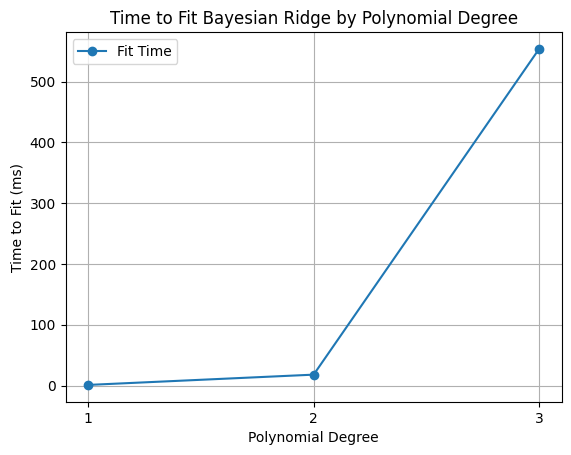

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 0) # Use lowest resolution atlas
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] #  gives subject age on standard units after z-scoring

input_variables = input_variables[:,:50] # First 50 columns
X_train, X_test = input_variables[:90], input_variables[90:] # First 90 as train set
y_train, y_test = output_variable[:90], output_variable[90:] # Last 10 as test set

degrees = range(1, 4) # Degrees 1 to 3
fit_times = [] # Store fit times

for degree in degrees: # Iterate through degrees
    poly = PolynomialFeatures(degree=degree) # Create PolynomialFeatures object
    X_train_poly = poly.fit_transform(X_train) # Fit & transform training data
    
    model_q10 = BayesianRidge() # Create Bayesian Ridge model
    start_time = time() # Start time
    model_q10.fit(X_train_poly, y_train) # Fit model on training data
    end_time = time() # End time
    
    fit_time_ms = (end_time - start_time)*1000 # Convert to milliseconds
    fit_times.append(fit_time_ms) # Store the fit time

# Plot the results
plt.plot(degrees, fit_times, marker='o', label='Fit Time')
plt.xlabel('Polynomial Degree')
plt.ylabel('Time to Fit (ms)')
plt.xticks(degrees)
plt.title('Time to Fit Bayesian Ridge by Polynomial Degree')
plt.grid()
plt.legend()
plt.show()